<a href="https://colab.research.google.com/github/jefernandezec/s2s/blob/main/S2S.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# More on the How: Fundamentals of Survey-to-Survey Imputation

# **0. Setup**

It takes a while. Please run this section asap.

In [ ]:
install.packages(c("glmnet","transport","xgboost"))
library(glmnet)
library(ggplot2)
library(transport)
library(xgboost)
library(Matrix)



# **1. Creating a toy (yet realistic) dataset**

Set seed for reproducibility and simulate raw variables

In [ ]:
set.seed(1729)
n <- 1000

age             <- sample(18:79, n, replace = TRUE)
age_sq          <- age^2
house_ownership <- rbinom(n, 1, 0.6)   # 1 = owns house
employed    <- rbinom(n, 1, 0.7)   # 1 = employed
electricity     <- rbinom(n, 1, 0.8)   # 1 = has electricity
wallsbrick <- rbinom(n, 1, 0.75)   # 1 = walls material: brick
roofmetal  <- rbinom(n, 1, 0.25)   # 1 = roof material: brick
floordirt  <- rbinom(n, 1, 0.15)   # 1 = floor material: dirt
areaurban  <- rbinom(n, 1, 0.65)   # 1 = urban
hhsize     <- sample(1:8, n, replace = TRUE)

df <- data.frame(
  age, age_sq, house_ownership, employed, electricity,
  wallsbrick,roofmetal,floordirt,areaurban,hhsize
)

Define "actual" coefficients

In [ ]:
base_coeffs <- c(
  age             = 0.3,
  age_sq          = -0.002,
  house_ownership = 5,
  employed    = 10,
  electricity     = 8,
  wallsbrick     =3,
  roofmetal     = 4,
  floordirt     = -5,
  areaurban    =7
)

Simulate normal random noise and create per capita consumption

In [ ]:
noise=rnorm(n,sd=3) #alternative for normal noise
#noise=rexp(n, rate = 1/10) - 10
base_coeffs = matrix(base_coeffs,ncol=1)

#df$consumption_pc=exp(B_0 + as.matrix(df)%*%base_coeffs+noise) #alternative for normal noise
df$consumption_pc=as.matrix(df[,-10])%*%base_coeffs+noise

head(df)

Visualize the density plot

In [ ]:
ggplot(df, aes(x = consumption_pc)) +
  geom_density(fill = "skyblue", color = "blue") +
  theme_minimal()

# **2. Bring your best hat**
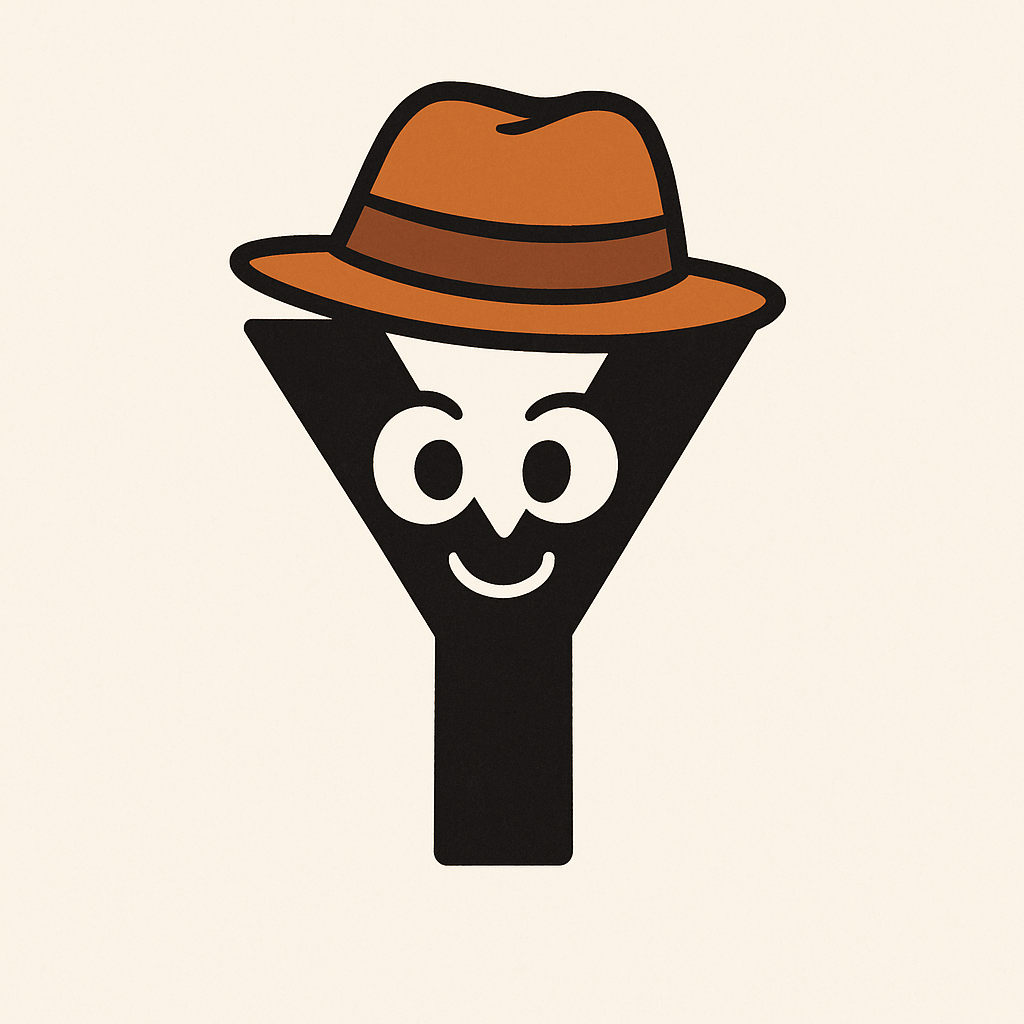



Adjust linear model for consumption_pc

In [ ]:
mod0=lm(consumption_pc ~ . , df)
summary(mod0)

Visualize residuals

In [ ]:
df$residuals = mod0$residuals

ggplot(df, aes(x = residuals)) +
  geom_density(fill = "skyblue", color = "blue") +
  theme_minimal()


How does the prediction look compared to the actual distribution?

In [ ]:
df$predicted <- predict(mod0)

ggplot(df, aes(x = consumption_pc)) +
  geom_density(aes(fill = "Actual"), alpha = 0.5) +
  geom_density(aes(x = predicted, fill = "Predicted"), alpha = 0.5) +
  scale_fill_manual(values = c("Actual" = "skyblue", "Predicted" = "lightcoral")) +
  theme_minimal() +
  labs(title = "Density Plot of Actual vs. Predicted Consumption per Capita",
       x = "Consumption per Capita",
       fill = "Distribution")

More realistic: dropping a **few** covariates

In [ ]:
mod1=lm(consumption_pc ~ age+age_sq+areaurban +electricity+house_ownership+roofmetal+hhsize, df)
summary(mod1)

Visualize residuals

In [ ]:
df$residuals = mod1$residuals

ggplot(df, aes(x = residuals)) +
  geom_density(fill = "skyblue", color = "blue") +
  theme_minimal()

And the prediction...

In [ ]:
df$predicted <- predict(mod1)

ggplot(df, aes(x = consumption_pc)) +
  geom_density(aes(fill = "Actual"), alpha = 0.5) +
  geom_density(aes(x = predicted, fill = "Predicted"), alpha = 0.5) +
  scale_fill_manual(values = c("Actual" = "skyblue", "Predicted" = "lightcoral")) +
  theme_minimal() +
  labs(title = "Density Plot of Actual vs. Predicted Consumption per Capita",
       x = "Consumption per Capita",
       fill = "Distribution")

Estimating poverty rate. Assume poverty line = 32.

In [ ]:
# Actual
cat("Actual poverty rate: ",mean(df$consumption_pc<32),"\n")

# Predicted
cat("Predicted poverty rate: ",mean(df$predicted<32))

Good enough. What if poverty line = 27

In [ ]:
# Actual
cat("Actual poverty rate: ",mean(df$consumption_pc<27),"\n")

# Predicted
cat("Predicted poverty rate: ",mean(df$predicted<27))

Uh-oh. Something went wrong. Let's explore.

In [ ]:
ggplot(df, aes(x = consumption_pc)) +
  stat_ecdf(aes(color = "Actual")) +
  stat_ecdf(aes(x = predicted, color = "Predicted")) +
  scale_color_manual(values = c("Actual" = "skyblue", "Predicted" = "lightcoral")) +
  theme_minimal() +
  geom_vline(xintercept =27)+
  geom_vline(xintercept =32)+
  labs(title = "ECDF Plot of Actual vs. Predicted Consumption per Capita",
       x = "Consumption per Capita",
       color = "Distribution")

Let's try to get a better hat using stepwise selection

In [ ]:
mod2=step(mod1)
summary(mod2)

In [ ]:
df$predicted <- predict(mod2)
# Actual
cat("Actual poverty rate: ",mean(df$consumption_pc<27),"\n")

# Predicted
cat("Predicted poverty rate: ",mean(df$predicted<27))


One more try. Let's lasso it.

In [ ]:
x <- model.matrix(consumption_pc ~ age+age_sq+areaurban +electricity+house_ownership+roofmetal, df)[,-1]
y <- df$consumption_pc
lasso_mod <- glmnet(x, y, alpha = 1)
df$predicted_lasso <- predict(lasso_mod, newx = x, s = min(lasso_mod$lambda)) # Use the minimum lambda

# Actual
cat("Actual poverty rate: ",mean(df$consumption_pc<27),"\n")

# Predicted Lasso
cat("Predicted lasso poverty rate: ",mean(df$predicted_lasso<27))

Not quite. How about the distribution

In [ ]:
ggplot(df, aes(x = consumption_pc)) +
  stat_ecdf(aes(color = "Actual")) +
  stat_ecdf(aes(x = predicted_lasso, color = "Predicted")) +
  scale_color_manual(values = c("Actual" = "skyblue", "Predicted" = "lightcoral")) +
  theme_minimal() +
  labs(title = "ECDF Plot of Actual vs. Predicted Consumption per Capita",
       x = "Consumption per Capita",
       color = "Distribution")

Root mean square error

In [ ]:
# Function to calculate RMSE
rmse <- function(actual, predicted) {
  sqrt(mean((actual - predicted)^2))
}

# Calculate RMSE for mod2
rmse_mod2 <- rmse(df$consumption_pc, df$predicted)
cat("RMSE for mod2:", rmse_mod2, "\n")

# Calculate RMSE for lasso_mod
rmse_lasso <- rmse(df$consumption_pc, df$predicted_lasso)
cat("RMSE for lasso_mod:", rmse_lasso, "\n")

R-squared

In [ ]:
# Function to calculate R-squared
rsquared <- function(actual, predicted) {
  rss <- sum((actual - predicted)^2)
  tss <- sum((actual - mean(actual))^2)
  1 - (rss / tss)
}

# Calculate R-squared for mod2
rsquared_mod2 <- rsquared(df$consumption_pc, df$predicted)
cat("R-squared for mod2:", rsquared_mod2, "\n")

# Calculate R-squared for lasso_mod
rsquared_lasso <- rsquared(df$consumption_pc, df$predicted_lasso)
cat("R-squared for lasso_mod:", rsquared_lasso, "\n")

Negligible differences. Let's go ahead with mod2 for simplicity and try some ML

XGBoost is a quick reliable choice

In [ ]:
# Prepare data for XGBoost
features <- df[, c("age","age_sq","areaurban","electricity","house_ownership","roofmetal")]
# Convert the dataframe to a matrix, which is required by xgboost
feature_matrix <- as.matrix(features)
# Create the DMatrix object
dtrain <- xgb.DMatrix(data = feature_matrix, label = df$consumption_pc)

# Define XGBoost parameters
params <- list(
  objective = "reg:squarederror", # Regression objective
  eval_metric = "rmse"           # Evaluation metric
)

# Train the XGBoost model
xgb_mod <- xgboost(data = dtrain, params = params, nrounds = 100)

# Generate predictions using the XGBoost model
df$predicted_xgb <- predict(xgb_mod, dtrain)

# Comparison metrics
# Density plot
ggplot(df, aes(x = consumption_pc)) +
  geom_density(aes(fill = "Actual"), alpha = 0.5) +
  geom_density(aes(x = predicted, fill = "mod2"), alpha = 0.5) +
  geom_density(aes(x = predicted_xgb, fill = "XGBoost"), alpha = 0.5) +
  scale_fill_manual(values = c("Actual" = "skyblue", "mod2" = "lightcoral", "XGBoost" = "lightgreen")) +
  theme_minimal() +
  labs(title = "Density Plot of Actual vs. Predicted Consumption per Capita (mod2 vs XGBoost)",
       x = "Consumption per Capita",
       fill = "Distribution")

# Poverty rate comparison (using poverty line = 27)
cat("Actual poverty rate: ",mean(df$consumption_pc<27),"\n")
cat("Predicted mod2 poverty rate: ",mean(df$predicted<27),"\n")
cat("Predicted XGBoost poverty rate: ",mean(df$predicted_xgb<27),"\n")

# R-squared comparison
rsquared_xgb <- rsquared(df$consumption_pc, df$predicted_xgb)
cat("R-squared for mod2:", rsquared_mod2, "\n")
cat("R-squared for XGBoost:", rsquared_xgb, "\n")

# RMSE comparison
rmse_xgb <- rmse(df$consumption_pc, df$predicted_xgb)
cat("RMSE for mod2:", rmse_mod2, "\n")
cat("RMSE for XGBoost:", rmse_xgb, "\n")

# **3. Complement your hat with a noise jacket**

Adding normal random noise and calculating the poverty rate

In [ ]:
df$prediction_plus_noise <- predict(mod2) + rnorm(n, sd = summary(mod2)$sigma)

cat("Predicted mod2 plus noise poverty rate: ",mean(df$prediction_plus_noise<27))

Promising. Now let's check the distributions.

In [ ]:
ggplot(df, aes(x = consumption_pc)) +
  geom_density(aes(fill = "Actual"), alpha = 0.5) +
  geom_density(aes(x = prediction_plus_noise, fill = "Predicted"), alpha = 0.5) +
  scale_fill_manual(values = c("Actual" = "skyblue", "Predicted" = "lightcoral")) +
  theme_minimal() +
  labs(title = "Density Plot of Actual vs. Predicted Consumption per Capita (Plus Noise)",
       x = "Consumption per Capita",
       fill = "Distribution")

 Looks good. Let's do it more times and see how poverty rates look

In [ ]:
simulations <- 20
poverty_rates <- numeric(simulations)
predicted_consumption_list <- list()

for (i in 1:simulations) {
  df$prediction_plus_noise <- predict(mod2) + rnorm(n, sd = summary(mod2)$sigma)
  poverty_rates[i] <- mean(df$prediction_plus_noise < 27)
  predicted_consumption_list[[i]] <- df$prediction_plus_noise
}

# Create a data frame for the poverty rates from simulations
poverty_rates_df <- data.frame(poverty_rate = poverty_rates)

# Plot the density of the poverty rates
ggplot(poverty_rates_df, aes(x = poverty_rate)) +
  geom_density(fill = "skyblue", color = "blue") +
  theme_minimal() +
  labs(title = "Density Plot of Poverty Rates from 20 Simulations",
       x = "Poverty Rate")

And the average poverty rate

In [ ]:
cat("Average predicted poverty rate:", mean(poverty_rates), "\n")

But we need one predicted vector. Let's average across simulations

In [ ]:
# Average the predicted consumption across simulations
df$avg_predicted_consumption <- rowMeans(do.call(cbind, predicted_consumption_list))

ggplot(df, aes(x = consumption_pc)) +
  geom_density(aes(fill = "Actual"), alpha = 0.5) +
  geom_density(aes(x = avg_predicted_consumption, fill = "Predicted"), alpha = 0.5) +
  scale_fill_manual(values = c("Actual" = "skyblue", "Predicted" = "lightcoral")) +
  theme_minimal() +
  labs(title = "Density Plot of Actual vs. Average Predicted Consumption per Capita (Plus Noise)",
       x = "Consumption per Capita",
       fill = "Distribution")


Low expectations here, but let’s take a look at the poverty rate

In [ ]:
cat("Poverty rate based on average predicted consumption:", mean(df$avg_predicted_consumption < 27), "\n")

Not again!

OK. Let's try something else. How do we choose one out the 20 simulations?

Debate: Why R-squared or RMSE would not solve our problem?

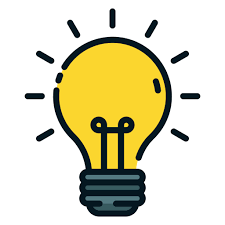

Let's choose the one that more closely resembles the original distribution.

First, let's define the distributional metric ->  Wasserstein distance (Kantorovich–Rubinstein metric)

In [ ]:
compute_wasserstein_distance <- function(original, predicted_matrix) {
  distances <- apply(predicted_matrix, 2, function(pred) {
    wasserstein1d(original, pred)
  })
  return(distances)
}

Now we will calculate the distributional distance between every simulation and the original vector and choose the closest one.

In [ ]:
distances <- compute_wasserstein_distance(df$consumption_pc, do.call(cbind, predicted_consumption_list))
closest_simulation_index <- which.min(distances)
closest_predicted_consumption <- predicted_consumption_list[[closest_simulation_index]]

# Add the closest predicted consumption vector to the data frame
df$closest_predicted_consumption <- closest_predicted_consumption

# Compare the distribution of the closest simulation with the actual data
ggplot(df, aes(x = consumption_pc)) +
  geom_density(aes(fill = "Actual"), alpha = 0.5) +
  geom_density(aes(x = closest_predicted_consumption, fill = "Closest Simulation"), alpha = 0.5) +
  scale_fill_manual(values = c("Actual" = "skyblue", "Closest Simulation" = "lightcoral")) +
  theme_minimal() +
  labs(title = "Density Plot of Actual vs. Closest Simulated Consumption per Capita",
       x = "Consumption per Capita",
       fill = "Distribution")

# Check the poverty rate for the closest simulation
cat("Poverty rate for the closest simulation:", mean(df$closest_predicted_consumption < 27), "\n")